### Introduction
This is an exploratory notebook for airbnb listings in Nairobi


In [1]:
# load modules
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# check version
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
Pandas: 1.1.3
Numpy: 1.19.2
Matplotlib: 3.3.2
Seaborn: 0.11.0


In [2]:
# load data
listings = pd.read_json('../data/listings.json')

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          280 non-null    object 
 1   url            0 non-null      float64
 2   info           0 non-null      float64
 3   description    280 non-null    object 
 4   details        280 non-null    object 
 5   is_superhost   124 non-null    object 
 6   price          280 non-null    object 
 7   total_reviews  280 non-null    object 
 8   review_score   280 non-null    object 
dtypes: float64(2), object(7)
memory usage: 19.8+ KB


In [4]:
listings.head()

,title,url,info,description,details,is_superhost,price,total_reviews,review_score
0,Entire apartment in Nairobi,NaN,NaN,Cozy 2 bedroom near popular restaurant,"[4 guests, 2 bedrooms, 3 beds, 2.5 baths, Wifi...",SUPERHOST,[$52],[],[]
1,Entire apartment in Nairobi,NaN,NaN,Brookview Kilimani 1 Bedroom (Monthly),"[2 guests, 1 bedroom, 1 bed, 1 bath, Wifi, Kit...",SUPERHOST,[$22],[],[]
2,Entire guesthouse in Nairobi,NaN,NaN,"Kileleshwa, 1 bedroom private cottage","[2 guests, 1 bedroom, 2 beds, 1 bath, Wifi, Ki...",None,[$10],"[ (, 5, )]",[5.0]
3,Entire apartment in Nairobi,NaN,NaN,"Cozy studio with CBD view, Netflix + rooftop pool","[2 guests, Studio, 1 bed, 1 bath, Wifi, Kitche...",None,[$25],"[ (, 33, )]",[4.64]
4,Entire apartment in Nairobi,NaN,NaN,SkyView Top Studio,"[2 guests, Studio, 1 bed, 1 bath, Wifi, Kitche...",SUPERHOST,[$25],"[ (, 11, )]",[5.0]


In [5]:
# replace specific values
listings.at[31,'details']= ['2 guests', '1 bedroom','1 bed', '1 bath', 'Wifi']
listings.at[73,'details'] = ['2 guests', '1 bedroom','1 bed', '1 bath', 'Wifi','Kitchen']
listings.at[230,'details'] = ['2 guests', 'Studio','1 bed', '1 bath', 'Wifi','Kitchen','Free parking']
listings.at[260,'details'] = ['1 guest', '1 bedroom','1 bed', '1 shared bath', 'Wifi','Kitchen','Free parking']
listings.at[104,'details'] = ['2 guests', 'Studio', '2 beds', '1 bath', 'Wifi','','Free parking']
listings.at[106,'details'] = ['2 guests', '1 bedroom', '1 bed', '1 bath', 'Wifi','', 'Free parking']
listings.at[169,'details'] = ['2 guests', '1 bedroom', '1 bed', '1 bath', 'Wifi','', 'Free parking']
listings.at[271,'details'] = ['2 guests', 'Studio', '1 bed', '1 bath', 'Wifi','', 'Free parking']
listings.at[278,'details'] = ['2 guests', 'Studio', '1 bed', '1 bath', 'Wifi','', 'Free parking']

In [6]:
# check total number of amenities offered
listings['total_amenities'] = listings['details'].apply(len)

# cleanup
listings[['guests','bedrooms','beds','baths','wifi','kitchen','parking','pool']] = listings['details'].apply(pd.Series)
listings['price($)'] = listings['price'].apply(pd.Series)
listings['rating'] = listings['review_score'].apply(pd.Series)
listings[['x','reviews','y']] = listings['total_reviews'].apply(pd.Series)
listings['price($)'] = listings['price($)'].str.replace('$','')
listings['price($)'] = listings['price($)'].astype(int)
listings['is_superhost'] = np.where(listings['is_superhost']=='SUPERHOST','yes','no')
listings = listings.drop(['x','y'],axis=1)
listings['rating'] = np.where(listings['rating'].isna(),0,listings['rating'])
listings['reviews'] = np.where(listings['reviews'].isna(),0,listings['reviews'])

# cleanup
listings['guests'] = listings['guests'].str.replace(' guests| guest', '')
listings['bedrooms'] = listings['bedrooms'].str.replace(' bedrooms| bedroom','')
listings['beds'] = listings['beds'].str.replace(' beds|bed','')
listings['bedrooms'] = listings['bedrooms'].str.replace('Studio','0')
listings['baths'] = listings['baths'].str.replace(' baths| bath','')
listings['baths'] = listings['baths'].str.replace('Half-bath','0.5')
listings['shared_bath'] = np.where(listings['baths'].str.contains('shared'),'yes','no')
listings['baths'] = listings['baths'].str.replace(' shared| private','')
listings['wifi'] = np.where(listings['wifi']=='Wifi','yes','no')
listings['kitchen'] = np.where(listings['kitchen']=='Kitchen','yes','no')
listings['parking'] = np.where(listings['parking']=='Free parking','yes','no')
listings['pool'] = np.where(listings['pool']=='Pool','yes','no')


In [7]:
# select clean columns
clean_cols = ['title','description','is_superhost','guests',
 'bedrooms','beds','baths','wifi','kitchen','parking','pool',
 'price($)','rating','reviews','shared_bath']
listings_clean = listings[clean_cols]
listings_clean.head()

,title,description,is_superhost,guests,bedrooms,beds,baths,wifi,kitchen,parking,pool,price($),rating,reviews,shared_bath
0,Entire apartment in Nairobi,Cozy 2 bedroom near popular restaurant,yes,4,2,3,2.5,yes,yes,yes,no,52,0,0,no
1,Entire apartment in Nairobi,Brookview Kilimani 1 Bedroom (Monthly),yes,2,1,1,1,yes,yes,yes,yes,22,0,0,no
2,Entire guesthouse in Nairobi,"Kileleshwa, 1 bedroom private cottage",no,2,1,2,1,yes,yes,yes,no,10,5.0,5,no
3,Entire apartment in Nairobi,"Cozy studio with CBD view, Netflix + rooftop pool",no,2,0,1,1,yes,yes,yes,yes,25,4.64,33,no
4,Entire apartment in Nairobi,SkyView Top Studio,yes,2,0,1,1,yes,yes,yes,no,25,5.0,11,no


In [8]:
# prices overview
listings_clean['price($)'].describe()

count    280.000000
mean      32.207143
std       16.548396
min        8.000000
25%       21.000000
50%       28.000000
75%       40.250000
max      101.000000
Name: price($), dtype: float64

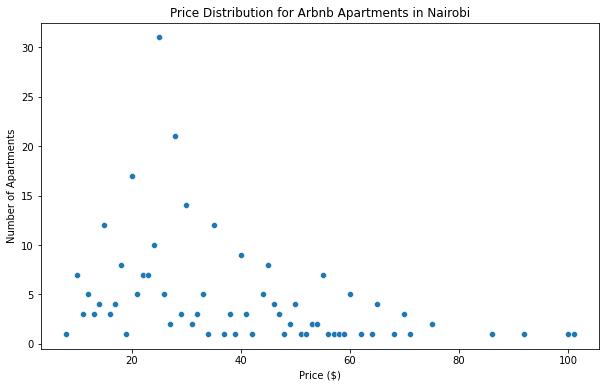

In [9]:
# plot price distribution
price_distribution = pd.DataFrame(listings_clean['price($)'].value_counts().reset_index())
price_distribution.columns =['price','total']
price_distribution = price_distribution.sort_values(by='price',ascending=True)
fig,ax = plt.subplots(figsize=(10,6))
# price_distribution.plot(kind='scatter',ax=ax)
sns.scatterplot(x='price', y='total',
            ci=None,
            palette="Blues_d",
#             orient='v',
            data=price_distribution)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Number of Apartments')
plt.title('Price Distribution for Arbnb Apartments in Nairobi')
plt.show()

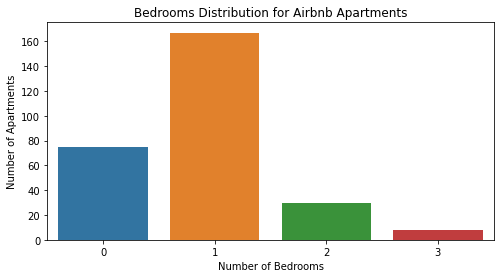

In [10]:
# distribution by bedrooms
bedrooms_distribution = listings_clean['bedrooms'].value_counts().reset_index()
bedrooms_distribution.columns = ['bedrooms','total']
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='bedrooms',y='total',order=['0','1','2','3'],data=bedrooms_distribution)

ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Apartments')
plt.title('Bedrooms Distribution for Airbnb Apartments')
plt.show()

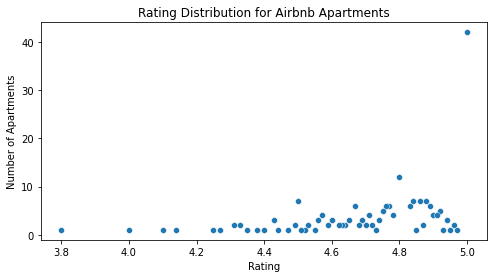

In [11]:
# distribution by bedrooms
rating_distribution = listings_clean['rating'].value_counts().reset_index()
rating_distribution.columns = ['rating','total']
rating_distribution['rating'] = rating_distribution['rating'].astype(float)
rating_distribution = rating_distribution[rating_distribution['rating']>0]
fig,ax=plt.subplots(figsize=(8,4))
sns.scatterplot(x='rating',y='total',data=rating_distribution)

ax.set_xlabel('Rating')
ax.set_ylabel('Number of Apartments')
plt.title('Rating Distribution for Airbnb Apartments')
plt.show()

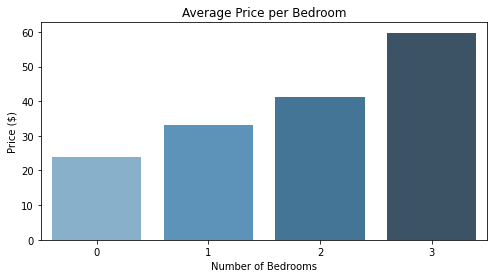

In [12]:
# let's check average prices per bedrooms
avg_price_per_bedroom = listings_clean.groupby('bedrooms')['price($)'].mean().rename('price').reset_index()

fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='bedrooms',y='price',palette='Blues_d',order=['0','1','2','3'],data=avg_price_per_bedroom)

ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Price ($)')
plt.title('Average Price per Bedroom')
plt.show()

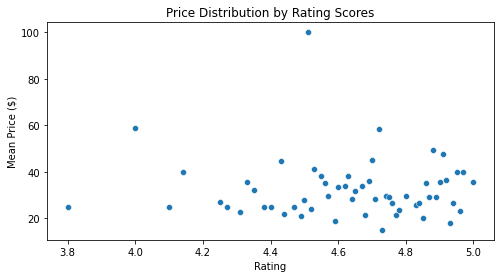

In [13]:
rating_greater_than_zero = listings_clean.copy()
rating_greater_than_zero['rating'] = rating_greater_than_zero['rating'].astype(float)
rating_greater_than_zero = rating_greater_than_zero[rating_greater_than_zero['rating']>0]

rating_distribution = rating_greater_than_zero.groupby('rating')['price($)'].mean().rename('price').reset_index()

fig,ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x='rating',y='price',data=rating_distribution)
ax.set_xlabel('Rating')
ax.set_ylabel('Mean Price ($)')
plt.title('Price Distribution by Rating Scores')

plt.show()

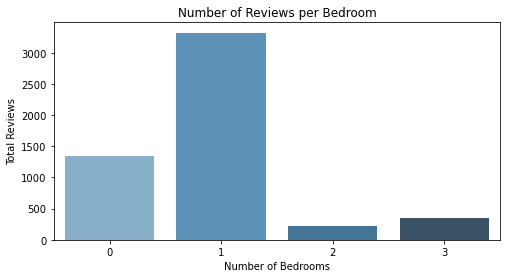

In [14]:
rating_greater_than_zero['reviews'] = rating_greater_than_zero['reviews'].astype(int)
reviews_summary = rating_greater_than_zero.groupby('bedrooms')['reviews'].sum().rename('total').reset_index()

fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='bedrooms',y='total',palette='Blues_d',order=['0','1','2','3'],data=reviews_summary)

ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Total Reviews')
plt.title('Number of Reviews per Bedroom')
plt.show()

In [15]:
listings_clean.rename(columns={'price($)':'price'},inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
listings_clean.head()

,title,description,is_superhost,guests,bedrooms,beds,baths,wifi,kitchen,parking,pool,price,rating,reviews,shared_bath
0,Entire apartment in Nairobi,Cozy 2 bedroom near popular restaurant,yes,4,2,3,2.5,yes,yes,yes,no,52,0,0,no
1,Entire apartment in Nairobi,Brookview Kilimani 1 Bedroom (Monthly),yes,2,1,1,1,yes,yes,yes,yes,22,0,0,no
2,Entire guesthouse in Nairobi,"Kileleshwa, 1 bedroom private cottage",no,2,1,2,1,yes,yes,yes,no,10,5.0,5,no
3,Entire apartment in Nairobi,"Cozy studio with CBD view, Netflix + rooftop pool",no,2,0,1,1,yes,yes,yes,yes,25,4.64,33,no
4,Entire apartment in Nairobi,SkyView Top Studio,yes,2,0,1,1,yes,yes,yes,no,25,5.0,11,no


In [17]:
listings_final = listings_clean.drop(['title','description'],axis=1)
listings_final['reviews'] = listings_final['reviews'].astype(int)
listings_final['rating'] = listings_final['rating'].astype(float)
listings_final['guests'] = listings_final['guests'].astype(int)
listings_final['baths'] = listings_final['baths'].astype(float)
listings_final['bedrooms'] = listings_final['bedrooms'].astype(int)
listings_final['beds'] = listings_final['beds'].astype(int)
listings_final.head()

,is_superhost,guests,bedrooms,beds,baths,wifi,kitchen,parking,pool,price,rating,reviews,shared_bath
0,yes,4,2,3,2.5,yes,yes,yes,no,52,0.00,0,no
1,yes,2,1,1,1.0,yes,yes,yes,yes,22,0.00,0,no
2,no,2,1,2,1.0,yes,yes,yes,no,10,5.00,5,no
3,no,2,0,1,1.0,yes,yes,yes,yes,25,4.64,33,no
4,yes,2,0,1,1.0,yes,yes,yes,no,25,5.00,11,no


In [18]:
listings_final.describe()

,guests,bedrooms,beds,baths,price,rating,reviews
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,2.314286,0.896429,1.164286,1.273214,32.207143,3.539607,18.700000
std,0.995227,0.693018,0.646032,0.510987,16.548396,2.094372,25.312442
min,1.000000,0.000000,0.000000,0.500000,8.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,1.000000,21.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,28.000000,4.710000,10.000000
75%,2.000000,1.000000,1.000000,1.500000,40.250000,4.880000,25.000000
max,10.000000,3.000000,6.000000,4.000000,101.000000,5.000000,182.000000


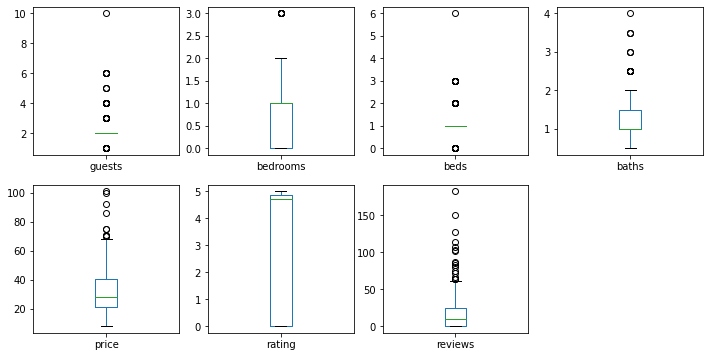

In [19]:
# plot summary for int values
listings_final.plot(kind='box', subplots=True,layout=(2,4),
                    sharex=False,sharey=False, figsize=(12,6))
plt.show()

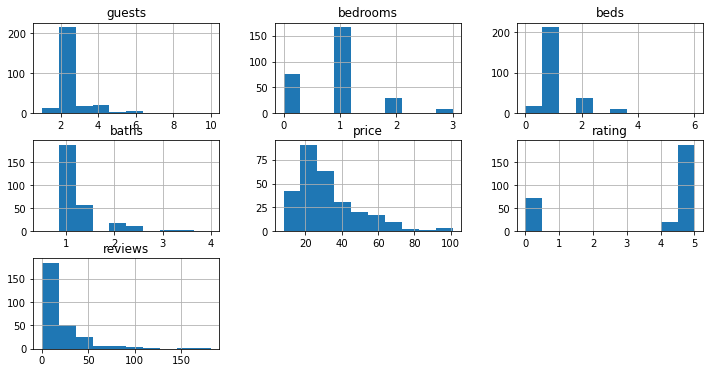

In [20]:
# fig,ax = plt.subplots(figsize=(12,6))
listings_final.hist(figsize=(12,6))
plt.show()

In [21]:
# # scale listings data
# listings_final_scaled = listings_final.copy()

# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# cols_to_scale = ['guests', 'bedrooms','beds', 'baths', 'rating', 'reviews']
# listings_final_scaled[cols_to_scale] = scaler_X.fit_transform(listings_final_scaled[cols_to_scale])
# listings_final_scaled['price'] = scaler_y.fit_transform(listings_final_scaled['price'])
# listings_final_scaled.head()


In [22]:
listings_ml = pd.get_dummies(listings_final)

In [23]:
listings_ml.head()

,guests,bedrooms,beds,baths,price,rating,reviews,is_superhost_no,is_superhost_yes,wifi_yes,kitchen_no,kitchen_yes,parking_no,parking_yes,pool_no,pool_yes,shared_bath_no,shared_bath_yes
0,4,2,3,2.5,52,0.00,0,0,1,1,0,1,0,1,1,0,1,0
1,2,1,1,1.0,22,0.00,0,0,1,1,0,1,0,1,0,1,1,0
2,2,1,2,1.0,10,5.00,5,1,0,1,0,1,0,1,1,0,1,0
3,2,0,1,1.0,25,4.64,33,1,0,1,0,1,0,1,0,1,1,0
4,2,0,1,1.0,25,5.00,11,0,1,1,0,1,0,1,1,0,1,0


## 2. Machine Learning

In [24]:
# split the data into training 
# & validation set

# generate random indices
val = 0.10
len_dataset = len(listings_ml)
val_indices = [x for x in np.random.randint(0, len_dataset,int(val*len_dataset))]
print(val_indices)

# split the dataset based on indices
validation = listings_ml.loc[listings_ml.index.isin(val_indices)]
train = listings_ml.loc[~listings_ml.index.isin(val_indices)]
validation.head()

[51, 44, 36, 251, 232, 114, 112, 5, 94, 222, 275, 168, 6, 253, 213, 197, 167, 237, 225, 103, 221, 212, 203, 25, 40, 167, 208, 135]


,guests,bedrooms,beds,baths,price,rating,reviews,is_superhost_no,is_superhost_yes,wifi_yes,kitchen_no,kitchen_yes,parking_no,parking_yes,pool_no,pool_yes,shared_bath_no,shared_bath_yes
5,2,1,1,1.5,47,5.00,20,1,0,1,0,1,0,1,0,1,1,0
6,2,1,1,1.0,30,4.67,18,1,0,1,0,1,0,1,1,0,1,0
25,2,1,1,1.5,10,4.77,13,1,0,1,0,1,0,1,0,1,1,0
36,2,1,1,1.0,40,4.94,51,1,0,1,0,1,0,1,1,0,1,0
40,2,0,1,1.0,24,4.84,38,0,1,1,0,1,0,1,0,1,1,0


In [25]:
print("Train Set: ",len(train),"Test Set: ", len(validation))

Train Set:  253 Test Set:  27


In [26]:
# validation set
val_test = validation.drop('price',axis=1)
val_actual = validation['price']

# train data into train & test sets
train = train.reset_index(drop=True)
X = train.drop('price',axis=1)
y = train['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

# scale_data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [27]:
# train rf model
rf_model = RandomForestRegressor(n_estimators=2000,criterion='mse',verbose=0)
rg_model = DecisionTreeRegressor(max_depth=5)
svm_model = SVR()
lasso_model = Lasso(alpha=1.0)
ridge_model = Ridge(alpha=1.0)
linear_model = LinearRegression()
gbr_model = GradientBoostingRegressor(max_depth=3,n_estimators=1000,learning_rate=0.001)
xgb_model = xgboost.XGBRegressor()
neighbors_model = KNeighborsRegressor(n_neighbors=2)

model_scores = []

models = [rf_model, rg_model, svm_model,
          lasso_model,ridge_model,linear_model,
         gbr_model,xgb_model,neighbors_model]
for model in models:
    model_score = {}
    model_score['Model'] = str(model).split('(')[0]
    
    fit_model = model.fit(X_train_scaled,y_train)            # fit model
    
    X_test_scaled = scaler.transform(X_test)
    y_pred = [round(x,0) for x in fit_model.predict(X_test_scaled)]     # test performance on test set
    mse = round(mean_squared_error(y_pred,y_test),2)
    rmse = round(mse**0.5,2)
    model_score['test_mse']= mse
    model_score['test_rmse']= rmse

    val_test_scaled = scaler.transform(val_test)
    val_pred = model.predict(val_test_scaled)                 # test performance on validation set
    mse_val = round(mean_squared_error(val_actual,val_pred),2)
    rmse_val = round(mse_val**0.5,2)
    model_score['validation_mse'] = mse_val
    model_score['validation_rmse'] = rmse_val
    
    model_scores.append(model_score)                  # add model result to scores list

    
model_scores_df = pd.DataFrame(model_scores)
# print(model_scores_df)
model_scores_df = model_scores_df.sort_values(by='validation_rmse',ascending=True)
model_scores_df

,Model,test_mse,test_rmse,validation_mse,validation_rmse
0,RandomForestRegressor,273.47,16.54,61.86,7.87
6,GradientBoostingRegressor,319.89,17.89,69.30,8.32
7,XGBRegressor,316.68,17.80,70.89,8.42
4,Ridge,297.45,17.25,84.25,9.18
3,Lasso,360.50,18.99,84.98,9.22
5,LinearRegression,298.92,17.29,85.57,9.25
1,DecisionTreeRegressor,350.70,18.73,104.39,10.22
2,SVR,397.84,19.95,105.51,10.27
8,KNeighborsRegressor,390.47,19.76,225.60,15.02


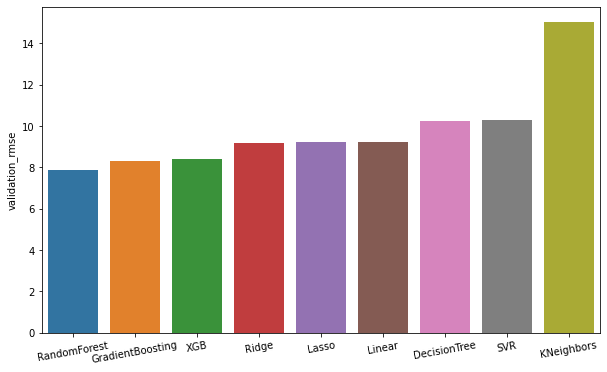

In [28]:
# define labels & xticks
labels = [x.split('Re')[0] for x in model_scores_df['Model']]
x_ticks = [x for x in range(len(labels))]

# plot model scores
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x='Model', y='validation_rmse', data=model_scores_df,ax=ax)
ax.set_xlabel('')
plt.xticks(rotation=10,ticks=x_ticks,labels=labels)
plt.show()

In [29]:
# make predictions using the model
rf_model.fit(X,y)
rg_model.fit(X,y)
ridge_model.fit(X,y)
neighbors_model.fit(X,y)
linear_model.fit(X,y)
rf_vals = [round(x,6) for x in rf_model.predict(val_test)]
dt_vals = [round(x,6) for x in rg_model.predict(val_test)]
rg_vals = [round(x,6) for x in ridge_model.predict(val_test)]
kn_vals = [round(x,6) for x in neighbors_model.predict(val_test)]
lnr_vals = [round(x,6) for x in linear_model.predict(val_test)]

results_df = pd.DataFrame({'RandomForest': rf_vals,
                           'DecisionTree': dt_vals,
                           'Ridge': rg_vals,
                           'Kneighbors': kn_vals,
                           'Linear':lnr_vals,
                           'actual': val_actual})
results_df.head(10)

,RandomForest,DecisionTree,Ridge,Kneighbors,Linear,actual
5,37.294500,48.500000,38.556387,34.0,38.677173,47
6,38.877500,28.100000,29.727057,24.0,29.764093,30
25,42.595250,36.266667,38.749687,18.5,38.868604,10
36,42.987625,28.100000,28.087822,22.5,28.123944,40
40,24.663600,24.339623,31.043308,22.0,31.030360,24
44,25.137500,24.339623,27.155786,35.0,27.156145,25
51,41.532335,34.055556,33.619484,38.5,33.678171,46
94,27.221256,28.100000,30.876899,33.0,30.919754,28
103,38.518558,33.666667,39.622311,22.5,39.802100,46
112,19.891107,24.339623,28.688429,36.5,28.654020,18


In [30]:
results_df.describe()

,RandomForest,DecisionTree,Ridge,Kneighbors,Linear,actual
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,32.655260,31.116137,31.554240,32.944444,31.598407,30.666667
std,8.153979,6.467143,5.828794,11.110748,5.888811,9.965324
min,19.891107,24.339623,19.347883,17.500000,19.309899,10.000000
25%,25.765591,26.219811,27.368701,25.250000,27.403235,24.500000
50%,32.201125,28.100000,32.404777,30.500000,32.434971,30.000000
75%,38.698029,34.055556,33.953057,38.250000,34.016516,36.500000
max,50.473002,48.500000,46.251487,63.500000,46.404343,47.000000


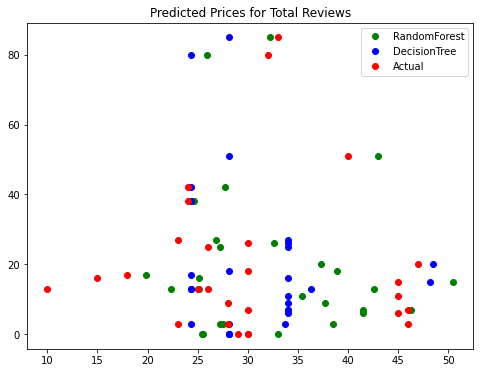

In [31]:
# plot results for RF & DT models
fig,ax=plt.subplots(figsize=(8,6))
plt.plot(results_df['RandomForest'],val_test['reviews'],'go', label='RandomForest')
plt.plot(results_df['DecisionTree'],val_test['reviews'],'bo', label='DecisionTree')
plt.plot(results_df['actual'],val_test['reviews'],'ro', label = 'Actual')
plt.title("Predicted Prices for Total Reviews")
plt.legend()
plt.show()

## Create Final Model: Linear/Ridge/RandomForest Regression


In [32]:
# prepare the data
X = listings_ml.drop('price',axis=1)
y = listings_ml['price']

# split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_train.to_csv('models/X_train_data.csv',index=False)

# create model
# model = RandomForestRegressor(n_estimators=2000,criterion='mse',max_depth=5)
model = Ridge()
model.fit(X_train_scaled,y_train)

# save model
pickle.dump(model,open('models/model_v1.pkl','wb'))

# load model
saved_model = pickle.load(open('models/model_v1.pkl','rb'))


In [33]:
X_test_scaled = scaler.transform(X_test)
mse = round(mean_squared_error(saved_model.predict(X_test_scaled),y_test),1)
rmse = round(mse**0.5,1)
print('\n',"MSE: ", mse,'\n',"RMSE:", rmse)


 MSE:  198.7 
 RMSE: 14.1


In [34]:
x_level = 10
round(saved_model.predict(X_test_scaled)[x_level],0)

27.0

In [35]:
x_val = X_test[x_level:x_level+1]
x_val

,guests,bedrooms,beds,baths,rating,reviews,is_superhost_no,is_superhost_yes,wifi_yes,kitchen_no,kitchen_yes,parking_no,parking_yes,pool_no,pool_yes,shared_bath_no,shared_bath_yes
221,1,1,1,1.0,0.0,0,1,0,1,0,1,0,1,1,0,1,0


In [36]:
y_test[x_level:x_level+1]

221    30
Name: price, dtype: int64

In [37]:
# linear regression features
important_features_dict = {}

model_coefficients = [x for x in saved_model.coef_]
model_columns = [x for x in X_train.columns]
linear_model_features = pd.DataFrame(list(zip(model_columns,model_coefficients)),columns=['feature','coef'])
linear_model_features['coef_abs'] = abs(linear_model_features['coef'])
linear_model_features = linear_model_features.sort_values(by='coef_abs',ascending=False)
linear_model_features.to_csv('models/feature_importances.csv',index=False)
linear_model_features

,feature,coef,coef_abs
3,baths,18.259417,18.259417
1,bedrooms,17.261190,17.261190
15,shared_bath_no,8.117689,8.117689
16,shared_bath_yes,-8.117689,8.117689
2,beds,5.157071,5.157071
12,parking_yes,4.230017,4.230017
11,parking_no,-4.230017,4.230017
9,kitchen_no,3.392751,3.392751
10,kitchen_yes,-3.392751,3.392751
13,pool_no,-3.354865,3.354865


In [38]:
# randomforest regression
# get feature importances

# important_features_dict = {}
# for x,i in enumerate(saved_model.feature_importances_):
#     important_features_dict[x]=i


# important_features_list = sorted(important_features_dict,
#                                  key=important_features_dict.get,
#                                  reverse=True)

# print('Most important features: %s' %important_features_list)

In [39]:
# # get feature names
# feature_names = [x for x in X_train.columns]

# # create feature importances df
# importances_df = pd.DataFrame(important_features_dict,index=[0]).melt().drop('variable',axis=1)
# importances_df.insert(loc=0,column='feature', value = feature_names)

# # save file
# importances_df.to_csv('models/feature_importances.csv',index=False)

# importances_df.sort_values(by='value',ascending=False)
